<a href="https://colab.research.google.com/github/kategimranova/paragraph_boundary_detection/blob/main/Paragraph_boundary_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import json
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import math
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
!pip install -U sentence-transformers

Известно, что лучшие вектора для предложений получаются из хорошо обученных языковых моделей. Поэтому я решила использовать предобученную модель для векторизации предложений SBERT (https://www.sbert.net)

In [80]:
from sentence_transformers import SentenceTransformer, util

Я выбрала модель *distiluse-base-multilingual-cased*, потому что в ней есть русский язык, что нам и нужно

In [81]:
model = SentenceTransformer('distiluse-base-multilingual-cased')

Для двух векторов мы можем посчитать косинусное сходство: чем больше similarity между векторами предложений, тем больше предложения похожи друг на друга
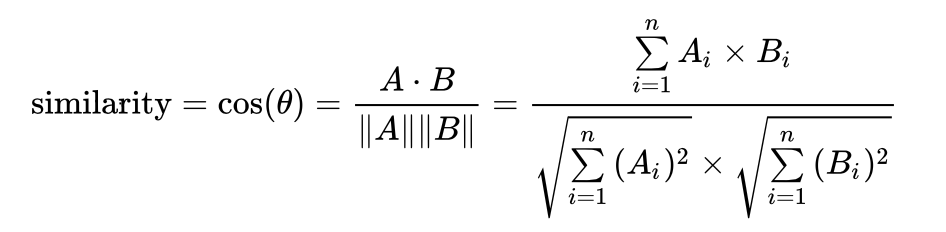

In [82]:
#Получение файла с данными
!wget https://raw.githubusercontent.com/kategimranova/paragraph_boundary_detection/main/data.jsonl -O ./data.jsonl

--2022-10-20 14:48:13--  https://raw.githubusercontent.com/kategimranova/paragraph_boundary_detection/main/data.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22753518 (22M) [text/plain]
Saving to: ‘./data.jsonl’

./data.jsonl        100%[===================>]  21.70M   131MB/s    in 0.2s    

2022-10-20 14:48:16 (131 MB/s) - ‘./data.jsonl’ saved [22753518/22753518]



In [83]:
with open('data.jsonl') as f:
    contents = f.readlines()

In [84]:
#Получение текста из файла по номеру
def get_text(i):
  return json.loads(contents[i])

#Получение списка предложений текста из файла по номеру
def get_sentences(text):
  return [sentence[0] for sentence in text]

#Получение меток (1 - если предложение является началом абзаца, 0 - в обратном случае)
def get_labels(text):
  labels = [sentence[1] for sentence in text]
  #Меняем все 2 на 1, так как начало секций должно совпадать с началом абзацев
  for i in range(len(labels)):
    if labels[i] == 2:
      labels[i] = 1
  return labels

In [85]:
#На примере самого первого текста:
text0 = get_text(0)
sentences0 = get_sentences(text0)
labels0 = get_labels(text0)
print(sentences0[:5])
print(labels0[:5])

['С 1768 года Россия ведёт войну против Османской империи.', 'В середине января 1770 года корпус генерала Христофора Штофельна, призванный очистить Молдавию и Валахию от турок, разместился в столице Молдавского княжества городе Яссы.', 'Там русскую армию встретил враг, по жестокости не уступающий башибузукам – чума.', 'За зиму она унесла жизни нескольких тысяч солдат.', 'Вскоре эпидемия вспыхнула в близлежащей Польше, а в августе достигла Киева: к началу ноября 1770 года из 20-ти тысяч жителей города умерло более шести.']
[1, 0, 0, 0, 1]


Идею для алгоритма я взяла из статьи https://medium.com/@npolovinkin/how-to-chunk-text-into-paragraphs-using-python-8ae66be38ea6

Идея алгоритма: подаются предложения из текста. Для каждого предложения мы считаем вектор с помощью предобученной модели. Далее для каждого предложения с каждым последующим из *n* предложений мы считаем косинусное сходство (строим матрицу сходства)
(на рисунке ниже зеленые квадраты - косинусное сходство предложения с предложением сразу после него, синими - сходство предложения с предложением через один и т.д.) и приводим к матрице, как показано на рисунке. Далее для каждого предложения (строки в матрице) применяем веса таким образом,что наиболее "похожие" по косинусу предложения имеют больший вес,  и считаем взвешенную сумму (для этого используется обратная сигмоида). Идея в том, чтобы найти локальные минимумы и эти точки считать началами новых абзацев.


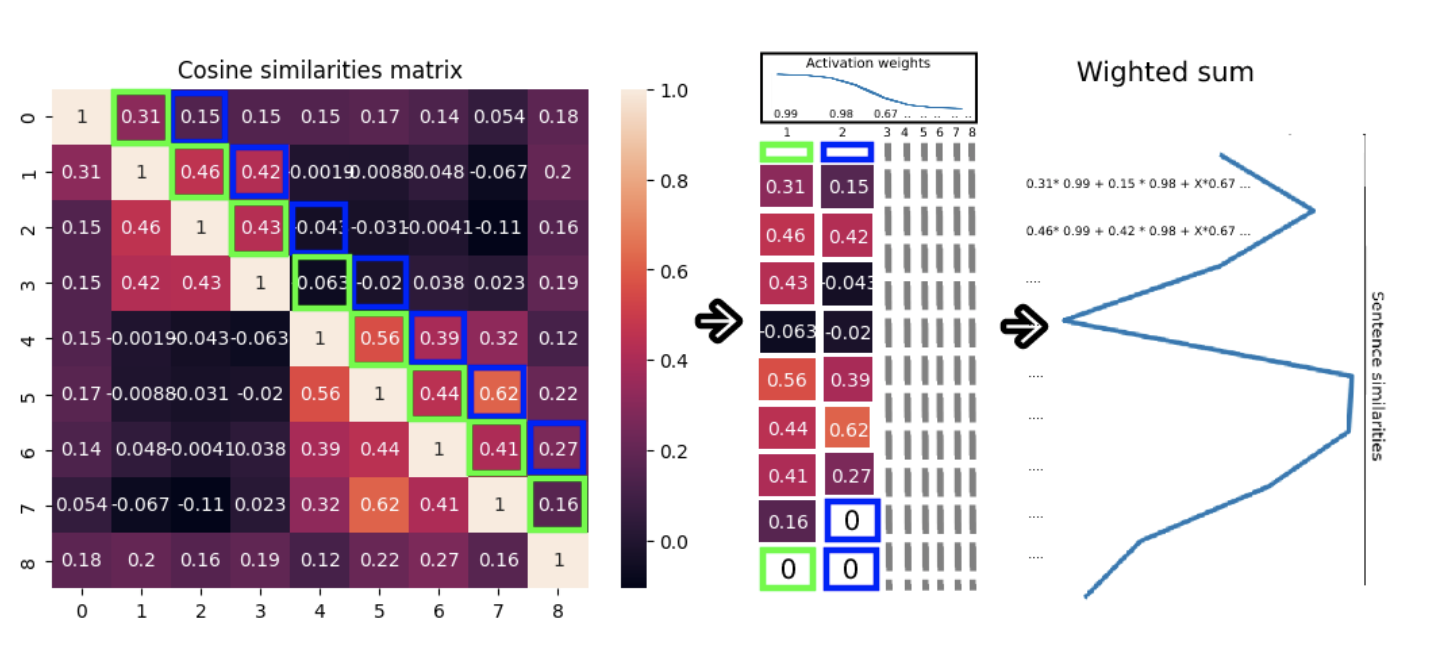

In [86]:
def make_paragraphs(text):
  sentences = get_sentences(text)
  embeddings = model.encode(sentences)
  similarities = cosine_similarity(embeddings)
  activated_similarities = activate_similarities(similarities, p_size=5)
  fig, ax = plt.subplots()
  minmimas = argrelextrema(activated_similarities, np.less, order=2)
  sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax);
  plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1,  label='vline_multiple - full height')
  split_points = [each for each in minmimas[0]]
  result = ''
  res_labels = [0]*len(sentences)
  for num,each in enumerate(sentences):
      if num - 1 in split_points:
          result+=f'\n\n {each} '
          res_labels[num] = 1
      else:
        result+=f'{each} '
  return res_labels, result

In [87]:
def rev_sigmoid(x):  
    return (1 / (1 + math.exp(0.5*x)))
    
def activate_similarities(similarities, p_size=10):
        x = np.linspace(-10,10,p_size)
        y = np.vectorize(rev_sigmoid) 
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        diagonals = np.stack(diagonals)
        diagonals = diagonals * activation_weights.reshape(-1,1)
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

In [88]:
def get_scores(res_labels, target_labels):
  return f'''Accuracy: {round(accuracy_score(res_labels, target_labels),3)}
F1: {round(f1_score(res_labels, target_labels),3)}
Recall: {round(recall_score(res_labels, target_labels),3)}
Precision: {round(precision_score(res_labels, target_labels),3)}'''

На примере первого текста:

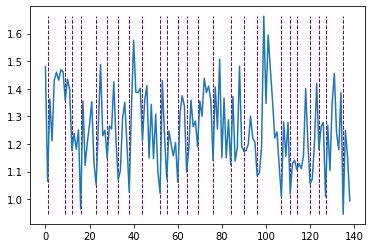

In [89]:
res_labels, result = make_paragraphs(text0)

In [90]:
print(get_scores(res_labels, labels0))

Accuracy: 0.647
F1: 0.347
Recall: 0.52
Precision: 0.26


In [91]:
print(result) 

С 1768 года Россия ведёт войну против Османской империи. В середине января 1770 года корпус генерала Христофора Штофельна, призванный очистить Молдавию и Валахию от турок, разместился в столице Молдавского княжества городе Яссы. 

 Там русскую армию встретил враг, по жестокости не уступающий башибузукам – чума. За зиму она унесла жизни нескольких тысяч солдат. Вскоре эпидемия вспыхнула в близлежащей Польше, а в августе достигла Киева: к началу ноября 1770 года из 20-ти тысяч жителей города умерло более шести. Несмотря на то, что ещё весной бушующую в Молдавии и Польше болезнь назвали чумой, киевские врачи диагностировали лишь гнилую горячку с пятнами (тиф) и не посчитали нужным вводить карантин. Распространение чумы продолжилось, и осенью она проникла в Москву. В течение последующего года количество умерших от моровой язвы – так в обиходе называют чуму – в Первопрестольной столице росло в геометрической прогрессии и к октябрю 1771 года достигло 700-800 человек в день. О том, как измени

Как мы можем видеть, скоры для текста получились небольшими, но если посмотреть, как алгоритм разделил текст на абзацы, то можем увидеть, что сделал он это довольно не плохо.

Другая идея для разбиения текста на абзацы - рассмотреть задачу сегментации как задачу бинарной классификации. Модель BERT показывает хорошие результаты для бин классификации. На вход подаются два предложения и сепаратор между ними. Если между ними есть переход на новый абзац, то считаем это положительным классом, если нет - то негативным.

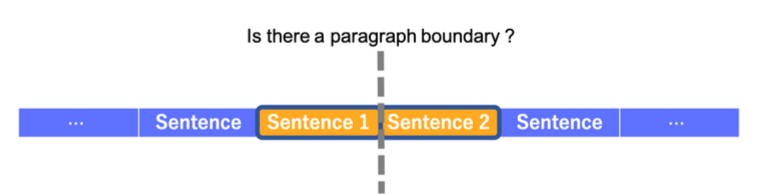

(к сожалению, я слишком поздно узнала об отборе, поэтому времени на реализацию этого алгоритма и более тщательной проверки первого алгоритма не было)